In [62]:
from pyspark.sql.functions import col, countDistinct, round, when, translate, max, min, isnull, isnan, count

In [63]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
NV_fulldf = spark.read.parquet(bucket_dir + 'VM2Uniform--NV--2021-06-13')

In [65]:
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 'CommercialData_Education',
        'CommercialData_AreaMedianEducationYears', 'CommercialDataLL_Interest_in_Education_Online_In_Household',
        'ElectionReturns_G16_Cnty_Margin_Clinton_D', 'ElectionReturns_G16_Cnty_Percent_Clinton_D', 
        'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Margin_Trump_R',
        'ElectionReturns_G16_Cnty_Percent_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G16CountyTurnoutDemocrats',
        'ElectionReturns_G16CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G16CountyTurnoutRepublicans']
NV_df = NV_fulldf.select(keep)

In [66]:
total_state_voters_NV = NV_df.select(countDistinct('LALVOTERID'))
total_state_voters_NV.show()

+--------------------------+
|count(DISTINCT LALVOTERID)|
+--------------------------+
|                   1866442|
+--------------------------+



<AxesSubplot:>

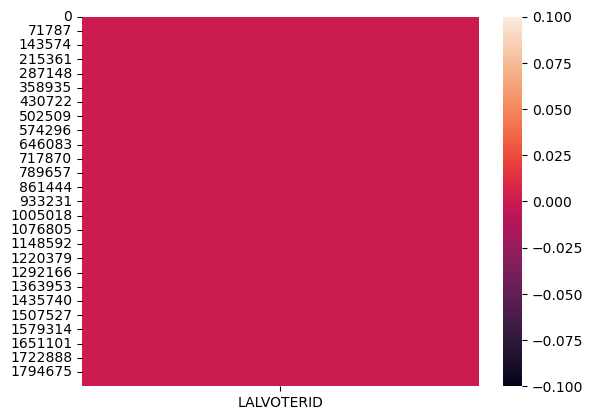

In [67]:
ID_list = NV_df.select('LALVOTERID')
ID_list_pd = ID_list.toPandas()
ID_tf = ID_list_pd.isnull()
sns.heatmap(data = ID_tf)

In [68]:
num_counties_NV = NV_df.select(countDistinct('County'))
num_counties_NV.show()

+----------------------+
|count(DISTINCT County)|
+----------------------+
|                    17|
+----------------------+



<AxesSubplot:>

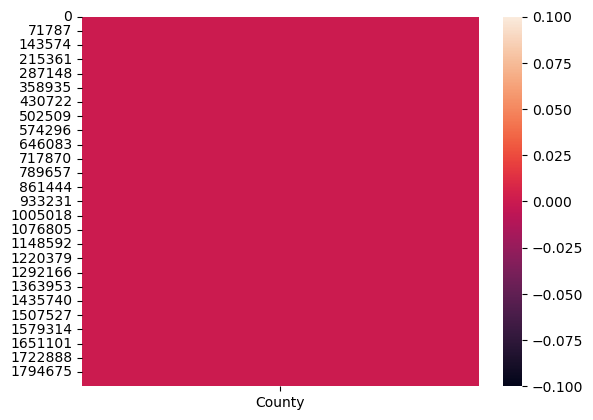

In [69]:
county_list = NV_df.select('County')
county_list_pd = county_list.toPandas()
county_tf = county_list_pd.isnull()
sns.heatmap(data = county_tf)

In [70]:
NV_df = NV_df.withColumnRenamed("ElectionReturns_G16CountyTurnoutAllRegisteredVoters", "CountyTurnoutAll") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutDemocrats", "CountyTurnoutDem") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutIndependentsAllOthers", "CountyTurnoutOther") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutRepublicans", "CountyTurnoutRep")
cty_voter_turnout_NV = NV_df.select('County', 'CountyTurnoutAll', 'CountyTurnoutDem',
                                'CountyTurnoutOther', 'CountyTurnoutRep').distinct().orderBy('County') # unique values per each county
cty_voter_turnout_NV.show()

+-----------+----------------+----------------+------------------+----------------+
|     County|CountyTurnoutAll|CountyTurnoutDem|CountyTurnoutOther|CountyTurnoutRep|
+-----------+----------------+----------------+------------------+----------------+
|CARSON CITY|             79%|             82%|               68%|             84%|
|  CHURCHILL|             74%|             75%|               63%|             79%|
|      CLARK|             65%|             68%|               53%|             74%|
|    DOUGLAS|             79%|             81%|               66%|             83%|
|       ELKO|             72%|             72%|               61%|             77%|
|  ESMERALDA|             72%|             68%|               61%|             77%|
|     EUREKA|             86%|             90%|               66%|             91%|
|   HUMBOLDT|             74%|             75%|               61%|             81%|
|     LANDER|             75%|             77%|               62%|          

In [71]:
cty_voter_turnout_NV = cty_voter_turnout_NV.withColumn('CountyTurnoutPrcnt', translate(col('CountyTurnoutAll'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntDem', translate(col('CountyTurnoutDem'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntRep', translate(col('CountyTurnoutRep'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntOther', translate(col('CountyTurnoutOther'),'%', ''))\
                    .drop('CountyTurnoutAll', 'CountyTurnoutDem', 'CountyTurnoutRep', 'CountyTurnoutOther')

from pyspark.sql.types import IntegerType
voter_turnout_NV_CLEAN = cty_voter_turnout_NV.withColumn('CountyTurnoutInt', cty_voter_turnout_NV['CountyTurnoutPrcnt'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutDemInt', cty_voter_turnout_NV['CountyTurnoutPrcntDem'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutRepInt', cty_voter_turnout_NV['CountyTurnoutPrcntRep'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutOtherInt', cty_voter_turnout_NV['CountyTurnoutPrcntOther'].cast(IntegerType()))\
                        .drop('CountyTurnoutPrcnt', 'CountyTurnoutPrcntDem', 'CountyTurnoutPrcntRep', 'CountyTurnoutPrcntOther')
voter_turnout_NV_CLEAN.show()

+-----------+----------------+-------------------+-------------------+---------------------+
|     County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-----------+----------------+-------------------+-------------------+---------------------+
|CARSON CITY|              79|                 82|                 84|                   68|
|  CHURCHILL|              74|                 75|                 79|                   63|
|      CLARK|              65|                 68|                 74|                   53|
|    DOUGLAS|              79|                 81|                 83|                   66|
|       ELKO|              72|                 72|                 77|                   61|
|  ESMERALDA|              72|                 68|                 77|                   61|
|     EUREKA|              86|                 90|                 91|                   66|
|   HUMBOLDT|              74|                 75|                 81|

In [72]:
voter_turnout_NV_CLEAN.select(max('CountyTurnoutInt'), max('CountyTurnoutDemInt'), max('CountyTurnoutRepInt'), max('CountyTurnoutOtherInt')).show()
voter_turnout_NV_CLEAN.select(min('CountyTurnoutInt'), min('CountyTurnoutDemInt'), min('CountyTurnoutRepInt'), min('CountyTurnoutOtherInt'))

+---------------------+------------------------+------------------------+--------------------------+
|max(CountyTurnoutInt)|max(CountyTurnoutDemInt)|max(CountyTurnoutRepInt)|max(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   86|                      90|                      91|                        74|
+---------------------+------------------------+------------------------+--------------------------+



DataFrame[min(CountyTurnoutInt): int, min(CountyTurnoutDemInt): int, min(CountyTurnoutRepInt): int, min(CountyTurnoutOtherInt): int]

In [73]:
NV_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutInt')==86) | (col('CountyTurnoutInt')==73))
NV_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
|EUREKA|              86|                 90|                 91|                   66|
+------+----------------+-------------------+-------------------+---------------------+



In [74]:
NV_dem_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutDemInt')==100) | (col('CountyTurnoutDemInt')==88))
NV_dem_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
|STOREY|              84|                 88|                 88|                   74|
+------+----------------+-------------------+-------------------+---------------------+



In [75]:
NV_rep_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutRepInt')==100) | (col('CountyTurnoutRepInt')==94))
NV_rep_turnout_max_min.show()
NV_rep_turnout_max_min.filter(col('CountyTurnoutRepInt')==100).count()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
+------+----------------+-------------------+-------------------+---------------------+



0

In [76]:
NV_other_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutOtherInt')==64) | (col('CountyTurnoutOtherInt')==46))
NV_other_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
+------+----------------+-------------------+-------------------+---------------------+



In [77]:
NV_df = NV_df.withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Clinton_D", "Cnty_Percent_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D", "Cnty_Vote_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Trump_R", "Cnty_Percent_R") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R", "Cnty_Vote_R")
election_results_NV = NV_df.select('County',
                                   'Cnty_Percent_D', 
                                   'Cnty_Vote_D',
                                   'Cnty_Percent_R', 
                                   'Cnty_Vote_R').distinct().orderBy('County')
election_results_NV.show()

+-----------+--------------+-----------+--------------+-----------+
|     County|Cnty_Percent_D|Cnty_Vote_D|Cnty_Percent_R|Cnty_Vote_R|
+-----------+--------------+-----------+--------------+-----------+
|CARSON CITY|           38%|       9610|           52%|      13125|
|  CHURCHILL|           20%|       2210|           72%|       7830|
|      CLARK|           52%|     402227|           42%|     320057|
|    DOUGLAS|           30%|       8454|           62%|      17415|
|       ELKO|           18%|       3401|           73%|      13551|
|  ESMERALDA|           15%|         65|           78%|        329|
|     EUREKA|            9%|         74|           85%|        723|
|   HUMBOLDT|           22%|       1386|           70%|       4521|
|     LANDER|           17%|        403|           76%|       1828|
|    LINCOLN|           13%|        285|           78%|       1671|
|       LYON|           26%|       6146|           67%|      16005|
|    MINERAL|           32%|        637|        

In [78]:
election_results_NV = election_results_NV.withColumn('Cnty_Prcnt_D', translate(col('Cnty_Percent_D'),'%', ''))\
                    .withColumn('Cnty_Prcnt_R', translate(col('Cnty_Percent_R'),'%', ''))\
                    .drop('Cnty_Percent_D', 'Cnty_Percent_R')

election_results_NV_CLEAN = election_results_NV.withColumn('Cnty_Prcnt_D_Int', election_results_NV['Cnty_Prcnt_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Prcnt_R_Int', election_results_NV['Cnty_Prcnt_R'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_D_Int', election_results_NV['Cnty_Vote_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_R_Int', election_results_NV['Cnty_Vote_R'].cast(IntegerType()))\
                        .drop('Cnty_Prcnt_D', 'Cnty_Prcnt_R', 'Cnty_Vote_D', 'Cnty_Vote_R')
election_results_NV_CLEAN.show()

+-----------+----------------+----------------+---------------+---------------+
|     County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+-----------+----------------+----------------+---------------+---------------+
|CARSON CITY|              38|              52|           9610|          13125|
|  CHURCHILL|              20|              72|           2210|           7830|
|      CLARK|              52|              42|         402227|         320057|
|    DOUGLAS|              30|              62|           8454|          17415|
|       ELKO|              18|              73|           3401|          13551|
|  ESMERALDA|              15|              78|             65|            329|
|     EUREKA|               9|              85|             74|            723|
|   HUMBOLDT|              22|              70|           1386|           4521|
|     LANDER|              17|              76|            403|           1828|
|    LINCOLN|              13|          

In [79]:
election_results_NV_CLEAN.select(max('Cnty_Prcnt_D_Int'), max('Cnty_Prcnt_R_Int')).show()
election_results_NV_CLEAN.select(min('Cnty_Prcnt_D_Int'), min('Cnty_Prcnt_R_Int')).show()

+---------------------+---------------------+
|max(Cnty_Prcnt_D_Int)|max(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   52|                   85|
+---------------------+---------------------+



+---------------------+---------------------+
|min(Cnty_Prcnt_D_Int)|min(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                    9|                   42|
+---------------------+---------------------+



In [80]:
NV_D_Prcnt_max_min = election_results_NV_CLEAN.filter((col('Cnty_Prcnt_D_Int')==73) | (col('Cnty_Prcnt_D_Int')==16))
NV_D_Prcnt_max_min.show()
NV_R_Prcnt_max_min = election_results_NV_CLEAN.filter((col('Cnty_Prcnt_R_Int')==77) | (col('Cnty_Prcnt_R_Int')==17))
NV_R_Prcnt_max_min.show()

+------+----------------+----------------+---------------+---------------+
|County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+----------------+----------------+---------------+---------------+
+------+----------------+----------------+---------------+---------------+



+------+----------------+----------------+---------------+---------------+
|County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+----------------+----------------+---------------+---------------+
+------+----------------+----------------+---------------+---------------+



<AxesSubplot:ylabel='County'>

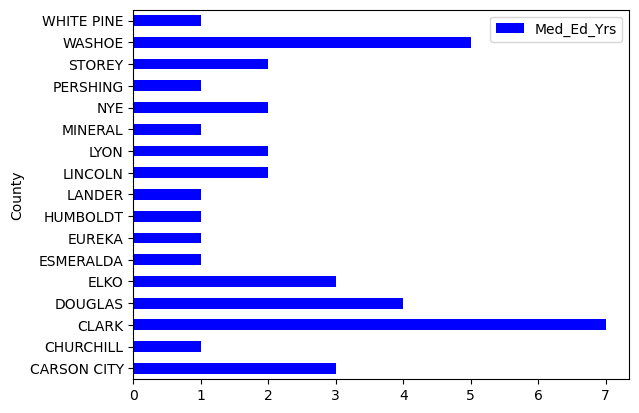

In [81]:
NV_df = NV_df.withColumnRenamed('CommercialData_AreaMedianEducationYears', 'Med_Ed_Yrs')
ed_yrs_by_cty_NV = NV_df.groupBy('County').agg(countDistinct('Med_Ed_Yrs')).orderBy('County')
ed_yrs_by_cty_NV = ed_yrs_by_cty_NV.withColumn('Med_Ed_Yrs', col('count(Med_Ed_Yrs)')).drop(col('count(Med_Ed_Yrs)'))
ed_yrs_by_cty_pd_NV = ed_yrs_by_cty_NV.toPandas()
ed_yrs_by_cty_pd_NV.plot(kind='barh', x='County', y='Med_Ed_Yrs', color='blue')

In [82]:
ed_yrs_by_cty_cnt_NV = ed_yrs_by_cty_NV.groupBy('Med_Ed_Yrs').agg(countDistinct('County')).orderBy('Med_Ed_Yrs')
ed_yrs_by_cty_cnt_NV.show()

+----------+-------------+
|Med_Ed_Yrs|count(County)|
+----------+-------------+
|         1|            8|
|         2|            4|
|         3|            2|
|         4|            1|
|         5|            1|
|         7|            1|
+----------+-------------+



In [83]:
ed_yr_turnout_NV = ed_yrs_by_cty_NV.join(voter_turnout_NV_CLEAN, 'County').orderBy('County').show()

+-----------+----------+----------------+-------------------+-------------------+---------------------+
|     County|Med_Ed_Yrs|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-----------+----------+----------------+-------------------+-------------------+---------------------+
|CARSON CITY|         3|              79|                 82|                 84|                   68|
|  CHURCHILL|         1|              74|                 75|                 79|                   63|
|      CLARK|         7|              65|                 68|                 74|                   53|
|    DOUGLAS|         4|              79|                 81|                 83|                   66|
|       ELKO|         3|              72|                 72|                 77|                   61|
|  ESMERALDA|         1|              72|                 68|                 77|                   61|
|     EUREKA|         1|              86|                 90|   

In [84]:
ed_lvl_combine = when(NV_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(NV_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(NV_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(NV_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(NV_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(NV_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
NV_df = NV_df.withColumn("Education_Lvl", ed_lvl_combine)

In [89]:
total_state_voters_NV = NV_df.select('LALVOTERID').count()
print('The total number of voters in the state of Nevada:', total_state_voters_NV)

ed_lvl_st_cnt_NV = NV_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt_NV = ed_lvl_st_cnt_NV.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state_NV = ed_lvl_st_cnt_NV.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters_NV)*100), 2))
ed_lvl_state_NV.show()

The total number of voters in the state of Nevada: 1866442


+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|     55265|          2.96|
|          HS Diploma|    273705|         14.66|
|         Bach Degree|    241777|         12.95|
|         Grad Degree|    119265|          6.39|
|Vocational Techni...|      1483|          0.08|
|        Some College|    281869|          15.1|
|                Null|    893078|         47.85|
+--------------------+----------+--------------+



<AxesSubplot:ylabel='Education_Lvl'>

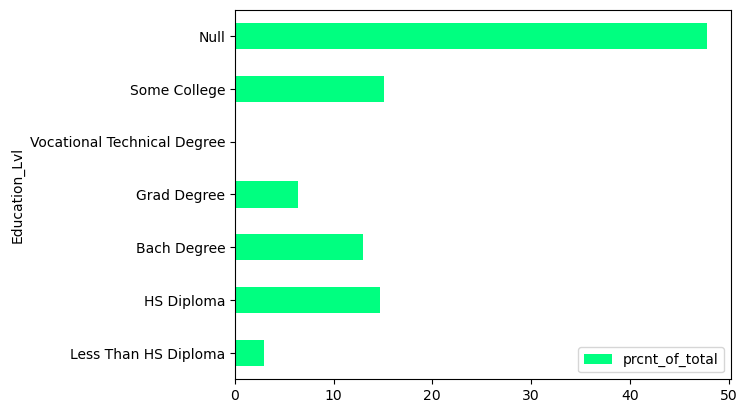

In [90]:
ed_lvl_state_pd_NV = ed_lvl_state_NV.toPandas()
ed_lvl_state_pd_NV.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', colormap='winter_r')

In [91]:
county_voters_NV = NV_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters_NV = county_voters_NV.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt_NV = NV_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt_NV = ed_lvl_county_cnt_NV.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county_NV = ed_lvl_county_cnt_NV.join(county_voters_NV, 'County').orderBy('County')
ed_lvl_by_county_NV = ed_lvl_by_county_NV.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county_NV.show()

+-----------+--------------------+--------------+-----------+--------------+
|     County|       Education_Lvl|ed_level_total|voter_total|prcnt_of_total|
+-----------+--------------------+--------------+-----------+--------------+
|CARSON CITY|          HS Diploma|          5687|      36026|         15.79|
|CARSON CITY|                Null|         15394|      36026|         42.73|
|CARSON CITY|        Some College|          6157|      36026|         17.09|
|CARSON CITY|Vocational Techni...|            29|      36026|          0.08|
|CARSON CITY|Less Than HS Diploma|          1129|      36026|          3.13|
|CARSON CITY|         Grad Degree|          2708|      36026|          7.52|
|CARSON CITY|         Bach Degree|          4922|      36026|         13.66|
|  CHURCHILL|Less Than HS Diploma|           480|      15837|          3.03|
|  CHURCHILL|         Grad Degree|           867|      15837|          5.47|
|  CHURCHILL|                Null|          6067|      15837|         38.31|

In [ ]:
## visualize distribution across counties for each level of education

## distribution of grad degrees per county
grad_dgs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Grad Degree")
grad_dgs_by_county_pd_NV = grad_dgs_by_county_NV.toPandas()
grad_dgs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Graduate Degree')

## distribution of bach degrees per county
bach_dgs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Bach Degree")
bach_dgs_by_county_pd_NV = bach_dgs_by_county_NV.toPandas()
bach_dgs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='magma', title='Bachelors Degree')

## distribution of vocational technical degrees per county
voc_dgs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Vocational Technical Degree")
voc_dgs_by_county_pd_NV = voc_dgs_by_county_NV.toPandas()
voc_dgs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='autumn', title='Vocational Technical Degree')

## distribution of some college per county
some_col_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Some College")
some_col_by_county_pd_NV = some_col_by_county_NV.toPandas()
some_col_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='twilight', title='Some College')
## distribution of hs diploma per county
hs_dip_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "HS Diploma")
hs_dip_by_county_pd_NV = hs_dip_by_county_NV.toPandas()
hs_dip_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='ocean', title='High School Diploma')

## distribution of less than hs diploma per county
less_thn_hs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Less Than HS Diploma")
less_thn_hs_by_county_pd_NV = less_thn_hs_by_county_NV.toPandas()
less_thn_hs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='seismic', title='Less Than High School Diploma')

## distribution of null education level per county
null_ed_lvl_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Null")
null_ed_lvl_by_county_pd_NV = null_ed_lvl_by_county_NV.toPandas()
null_ed_lvl_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='spring', title='Null Values')